### Imports & Setup 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

FEATURES_DIR = "features"
MODELS_DIR = "models"
OUTPUT_DIR = "output"

Path(MODELS_DIR).mkdir(exist_ok=True)
Path(OUTPUT_DIR).mkdir(exist_ok=True)


### Load HR feature dataset

In [2]:
hr_path = f"{FEATURES_DIR}/hr_features.csv"
hr_df = pd.read_csv(hr_path)

print("HR dataset:", hr_df.shape)
hr_df.head()

HR dataset: (1470, 49)


,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,Attrition_Flag
0,0.446350,0.742527,-1.010909,-0.891688,0.0,-1.701283,-0.660531,1.383138,0.379672,-0.057788,...,False,False,False,False,True,False,False,True,True,1
1,1.322365,-1.297775,-0.147150,-1.868426,0.0,-1.699621,0.254625,-0.240677,-1.026167,-0.057788,...,False,False,False,True,False,False,True,False,False,0
2,0.008343,1.414363,-0.887515,-0.891688,0.0,-1.696298,1.169781,1.284725,-1.026167,-0.961486,...,False,False,False,False,False,False,False,True,True,1
3,-0.429664,1.461466,-0.764121,1.061787,0.0,-1.694636,1.169781,-0.486709,0.379672,-0.961486,...,False,False,False,True,False,False,True,False,True,0
4,-1.086676,-0.524295,-0.887515,-1.868426,0.0,-1.691313,-1.575686,-1.274014,0.379672,-0.961486,...,False,False,False,False,False,False,True,False,False,0


### Identify Performance Column

In [3]:
possible_targets = ["PerformanceRating", "JobSatisfaction", "EnvironmentSatisfaction"]

target_col = None
for col in possible_targets:
    if col in hr_df.columns:
        target_col = col
        break

print("Detected performance target:", target_col)

if target_col is None:
    raise ValueError("Performance variable not found in dataset.")


Detected performance target: PerformanceRating


### Prepare X and y

In [4]:
y = hr_df[target_col]
X = hr_df.drop(columns=[target_col, "Attrition_Flag"], errors="ignore")

print("X shape:", X.shape, "y shape:", y.shape)


X shape: (1470, 47) y shape: (1470,)


### Train/Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (1176, 47) Test: (294, 47)


### Scale Numerical Features

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)


X_train_scaled shape: (1176, 47)
X_test_scaled shape: (294, 47)


### Train Regression Model

In [7]:
rf_model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
print("Model training complete.")


Model training complete.


### Evaluate Model

In [8]:
y_pred = rf_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Performance Model Evaluation:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R² Score:", r2)


Performance Model Evaluation:
MAE: 2.2587751774814196e-15
RMSE: 3.276634494919982e-15
R² Score: 1.0


### Feature Importance

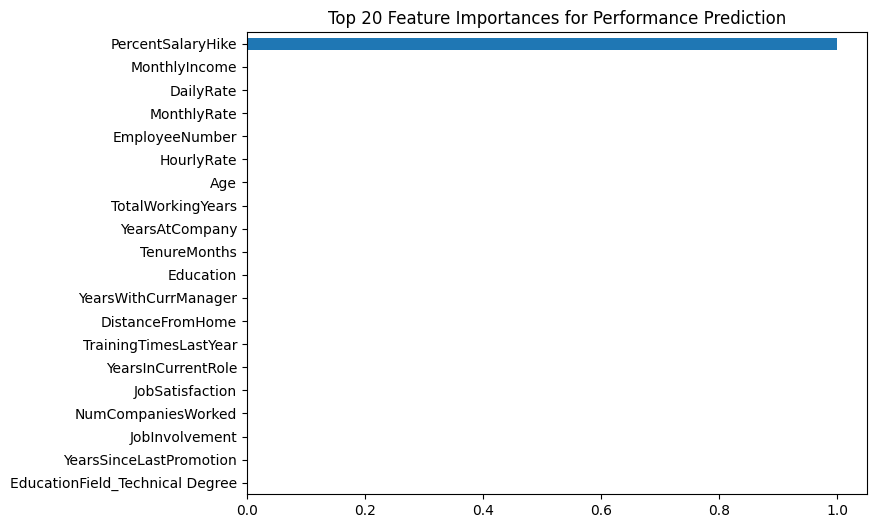

In [9]:
importances = rf_model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feat_imp.head(20).plot(kind='barh')
plt.title("Top 20 Feature Importances for Performance Prediction")
plt.gca().invert_yaxis()
plt.show()


### Save Performance Model

In [10]:
perf_model_path = f"{MODELS_DIR}/performance_model.pkl"
joblib.dump({"model": rf_model, "scaler": scaler, "features": X.columns.tolist()}, perf_model_path)

print("Performance model saved to:", perf_model_path)


Performance model saved to: models/performance_model.pkl


### PART B — EMPLOYEE CLUSTERING (KMeans)

In [11]:
cluster_features = [
    col for col in [
        "Age", "MonthlyIncome", "JobSatisfaction", 
        "EnvironmentSatisfaction", "TotalWorkingYears",
        "YearsAtCompany"
    ] if col in hr_df.columns
]

print("Clustering features:", cluster_features)

cluster_data = hr_df[cluster_features].dropna()

scaler_c = StandardScaler()
cluster_scaled = scaler_c.fit_transform(cluster_data)

print("Cluster data shape:", cluster_scaled.shape)
print("Cluster data features:", cluster_features)


Clustering features: ['Age', 'MonthlyIncome', 'JobSatisfaction', 'EnvironmentSatisfaction', 'TotalWorkingYears', 'YearsAtCompany']
Cluster data shape: (1470, 6)
Cluster data features: ['Age', 'MonthlyIncome', 'JobSatisfaction', 'EnvironmentSatisfaction', 'TotalWorkingYears', 'YearsAtCompany']


### Find Optimal k using Elbow Method

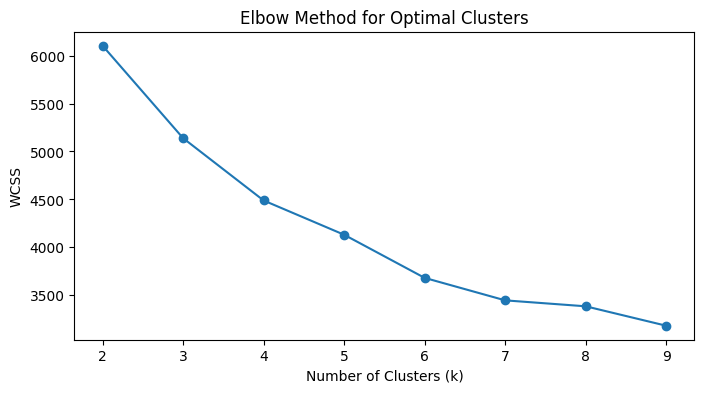

In [12]:
wcss = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K, wcss, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.show()


### Train Final KMeans Model

In [13]:
k = 4   # choose based on elbow plot
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(cluster_scaled)

cluster_data['Cluster'] = clusters
cluster_data.head()


,Age,MonthlyIncome,JobSatisfaction,EnvironmentSatisfaction,TotalWorkingYears,YearsAtCompany,Cluster
0,0.446350,-0.108350,1.153254,-0.660531,-0.421642,-0.164613,3
1,1.322365,-0.291719,-0.660853,0.254625,-0.164511,0.488508,0
2,0.008343,-0.937654,0.246200,1.169781,-0.550208,-1.144294,1
3,-0.429664,-0.763634,0.246200,1.169781,-0.421642,0.161947,1
4,-1.086676,-0.644858,-0.660853,-1.575686,-0.678774,-0.817734,3


### Visualize Clusters

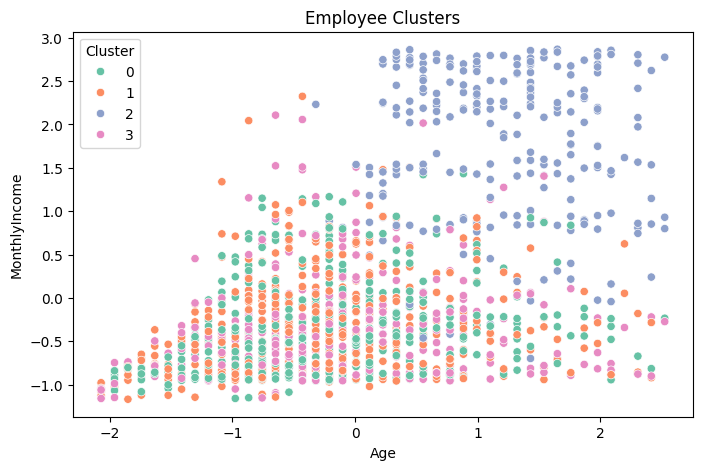

In [14]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x=cluster_data[cluster_features[0]],
    y=cluster_data[cluster_features[1]],
    hue=cluster_data["Cluster"],
    palette="Set2"
)
plt.title("Employee Clusters")
plt.show()


### Save Clusters

In [15]:
cluster_model_path = f"{MODELS_DIR}/employee_cluster_model.pkl"
joblib.dump({"model": kmeans, "scaler": scaler_c, "features": cluster_features}, cluster_model_path)

print("Cluster model saved to:", cluster_model_path)


Cluster model saved to: models/employee_cluster_model.pkl
